In [1]:
#!pip install ipdb

In [2]:
from wsi_registration import TissueDetector, MatcherParameters, WSI_Matcher
import logging
import math
import openslide
import numpy as np
from skimage.color import rgb2lab
import cv2
import matplotlib.pyplot as plt

In [3]:
# %pdb on
fixed_wsi = "/Users/jonlinks/Desktop/Testing Restianed Aligner/img/19652.tif"  # file name of your fixed (template) whole slide image
float_wsi = "/Users/jonlinks/Desktop/Testing Restianed Aligner/img/19653_e7.tif"  # file name of your float (moving) whole slide image
# define the tissue detector, so the patches can be sampled
tissue_detector = TissueDetector("LAB_Threshold", threshold=80) # option 1
# tissue_detector = TissueDetector("GNB", threshold=0.5)    # option 2
matcher_parameters = MatcherParameters()  # use the default parameters
matcher = WSI_Matcher(tissue_detector, matcher_parameters)

In [4]:
fixed_wsi_obj = openslide.OpenSlide(fixed_wsi)
float_wsi_obj = openslide.OpenSlide(float_wsi)

layer_rescale_factors = fixed_wsi_obj.level_downsamples[1:len(matcher.layer_patch_size) + 1]
thumbnail_fixed, thumbnail_float = matcher.get_thumbnails(fixed_wsi_obj, float_wsi_obj, matcher.rescale_rate)

#thumbnail_fixed = thumbnail_fixed.crop((0, 0, thumbnail_fixed.size[0], thumbnail_fixed.size[1]))
#thumbnail_float = thumbnail_float.crop((thumbnail_float.size[0], 0, thumbnail_float.size[0], thumbnail_float.size[1]))

In [5]:
print(fixed_wsi_obj.level_count)
print(float_wsi_obj.level_dimensions)


1
((31872, 31972),)


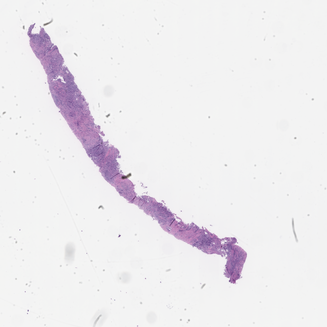

In [6]:
thumbnail_fixed

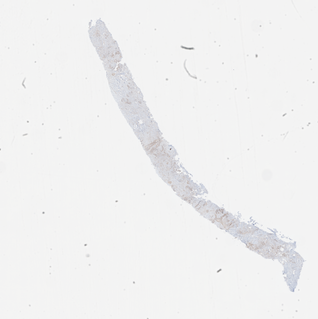

In [7]:
thumbnail_float

In [8]:
brisk = cv2.BRISK_create()
gray_fixed = cv2.cvtColor(np.array(thumbnail_fixed),cv2.COLOR_BGR2GRAY)
gray_float = cv2.cvtColor(np.array(thumbnail_float),cv2.COLOR_BGR2GRAY)
(kps_fixed, descs_fixed) = brisk.detectAndCompute(gray_fixed, None)
(kps_float, descs_float) = brisk.detectAndCompute(gray_float, None)
if (descs_fixed is None) or (descs_float is None):
    reg_status = 0
    init_reg_offset = (0, 0)
    print("not nice")
if len(kps_fixed) < 3 or len(kps_float) < 3:
    reg_status = 0
    init_reg_offset = (0, 0)
    print("not nice")
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)

matches = bf.match(descs_fixed, descs_float)
matches = sorted(matches, key = lambda x:x.distance)
if len(matches) < 3:  # less than 3 points
    reg_status = 0
    init_reg_offset = (0, 0)
    print("not nice")
if len(matches) <= 10:  # get first 10 points
    selected_matches = matches
else:
    selected_matches = matches[0:10]
selected_kps_fixed = []
selected_kps_float = []
for m in selected_matches:
    selected_kps_float.append(kps_float[m.trainIdx])
    selected_kps_fixed.append(kps_fixed[m.queryIdx])

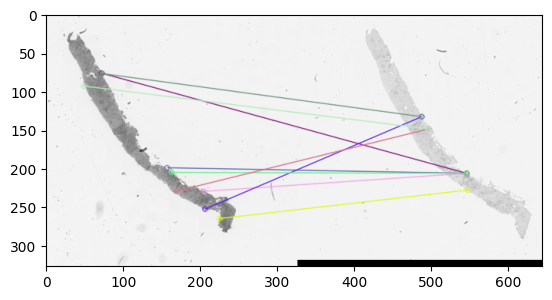

(<matplotlib.image.AxesImage at 0x1b8b2eb90>, None)

In [9]:
img3 = cv2.drawMatches(gray_fixed,kps_fixed,gray_float,kps_float,matches[1:10],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3),plt.show()

In [10]:
float_pts = cv2.KeyPoint_convert(selected_kps_float)
fixed_pts = cv2.KeyPoint_convert(selected_kps_fixed)

In [11]:
print(float_pts)
print(fixed_pts)

[[219.35306 206.23378]
 [219.35306 206.23378]
 [219.35306 206.23378]
 [219.35306 206.23378]
 [161.12086 132.77588]
 [219.35306 206.23378]
 [170.06964 148.68367]
 [220.66554 227.92398]
 [161.12086 132.77588]
 [170.06964 148.68367]]
[[157.85477  199.89633 ]
 [205.57741  229.59991 ]
 [157.01363  198.98898 ]
 [ 71.97355   76.29159 ]
 [206.35071  252.60965 ]
 [162.88065  205.08344 ]
 [168.69516  229.44925 ]
 [225.04922  264.99368 ]
 [ 72.890884  76.817764]
 [ 48.33666   92.933556]]


In [12]:
init_offset, status = matcher.get_initial_pos(thumbnail_fixed, thumbnail_float, 10)
init_offset, status

thumbnail_down_rate = 10

In [13]:
brisk = cv2.BRISK_create()
(kps_fixed, descs_fixed) = brisk.detectAndCompute(np.array(thumbnail_fixed), None)
(kps_float, descs_float) = brisk.detectAndCompute(np.array(thumbnail_float), None)
if (descs_fixed is None) or (descs_float is None):
    reg_status = 0
    init_reg_offset = (0, 0)
if len(kps_fixed) < 3 or len(kps_float) < 3:
    reg_status = 0
    init_reg_offset = (0, 0)
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
try:
    matches = bf.match(descs_fixed, descs_float)
    matches = sorted(matches, key=lambda x: x.distance)
    if len(matches) < 3:  # less than 3 points
        reg_status = 0
        init_reg_offset = (0, 0)
    if len(matches) <= 10:  # get first 10 points
        selected_matches = matches
    else:
        selected_matches = matches[0:10]
    selected_kps_fixed = []
    selected_kps_float = []
    for m in selected_matches:
        selected_kps_float.append(kps_float[m.trainIdx].pt)
        selected_kps_fixed.append(kps_fixed[m.queryIdx].pt)
    reprojThresh = 2
    confidence_ratio = 0.5
    (E, status) = cv2.estimateAffinePartial2D(np.float32(fixed_pts), np.float32(float_pts),
                                                ransacReprojThreshold=reprojThresh, confidence=confidence_ratio)
    if 0 not in status:
        theta = - math.atan2(E[0, 1], E[0, 0]) * 180 / math.pi
        print(theta)
        if abs(theta) > 1:
            reg_status = 0
            init_reg_offset = (0, 0)
        else:
            reg_status = 1
            init_reg_offset = (E[0, 2] * thumbnail_down_rate, E[1, 2] * thumbnail_down_rate)
    else:
        counts = np.count_nonzero(status == 0)
        if counts > 5:  # if over 50% fails
            reg_status = 0
            init_reg_offset = (0, 0)
        else:
            init_reg_offset = (E[0, 2] * thumbnail_down_rate, E[1, 2] * thumbnail_down_rate)
            reg_status = 1
except:
    reg_status = 0
    init_reg_offset = (0, 0)

In [14]:
init_reg_offset, reg_status

((2193.530578613281, 2062.337799072265), 1)

In [15]:
sample_cnt = 50
from_fixed_thumb = True
thumb_rescale=matcher.rescale_rate
fixed_foreground_mask = tissue_detector.predict(thumbnail_fixed, open_operation=True)
pos_indices = np.where(fixed_foreground_mask > 0)
print(pos_indices)
xy_idx = np.random.choice(pos_indices[0].shape[0], sample_cnt)
print(xy_idx)
if from_fixed_thumb:
    float_loc_y = np.array((pos_indices[1][xy_idx] * thumb_rescale) + init_offset[0]).astype(int)
    float_loc_x = np.array((pos_indices[0][xy_idx] * thumb_rescale) + init_offset[1]).astype(int)
else:
    float_loc_y = np.array((pos_indices[1][xy_idx] * thumb_rescale) - init_offset[0]).astype(int)
    float_loc_x = np.array((pos_indices[0][xy_idx] * thumb_rescale) - init_offset[1]).astype(int)
fixed_loc_y = np.array((pos_indices[1][xy_idx] * thumb_rescale)).astype(int)
fixed_loc_x = np.array((pos_indices[0][xy_idx] * thumb_rescale)).astype(int)
print([fixed_loc_x, fixed_loc_y], [float_loc_x, float_loc_y])

(array([ 30,  30,  30, ..., 282, 282, 282]), array([ 40,  41,  42, ..., 233, 234, 235]))
[5363 5067 4663 5434 2092 6423 1074 1057 5431  185 5634 5407  489 3134
 6599  904 3993 3221 3461 4733 2662 1611 3748 3934 4056 1899 4313 5324
 2216 3077 6564 5054 1098 1258 4130 2692 3080 3808 1281  374 1866 6004
 6521  638 5323 4006  755 5403  255 4263]
[array([23500, 22800, 21300, 23700, 11300, 26700,  7800,  7800, 23700,
        4200, 24100, 23600,  5400, 15000, 27900,  7100, 18500, 15300,
       16100, 21500, 13300,  9700, 17500, 18200, 18800, 10600, 20000,
       23400, 11700, 14800, 27600, 22700,  8000,  8600, 19200, 13400,
       14900, 17700,  8700,  4900, 10500, 24900, 27300,  5900, 23400,
       18600,  6400, 23600,  4500, 19800]), array([20400, 16700, 14900, 18900,  7000, 24100,  7100,  4800, 18600,
        3100, 20500, 20500,  3700, 10700, 23500,  5900, 12100,  9600,
       11100, 16800,  8000,  8300, 10800, 12900, 12500,  8400, 14300,
       20600,  8100, 11500, 23300, 19100,  5400,  5

In [16]:
fixed_foreground_mask = tissue_detector.predict(thumbnail_fixed, open_operation=True)
indices = {}
for i in range(len(fixed_wsi_obj.level_dimensions)):  # layers
    fixed_indices, float_indices = matcher.get_sample_locations(fixed_foreground_mask, init_reg_offset, matcher.layer_patch_max_num, thumb_rescale=matcher.rescale_rate, from_fixed_thumb=True)
    indices["level_"+str(i+1)] = (fixed_indices, float_indices)
indicies_dict = indices

In [17]:
indicies_dict

{'level_1': ([array([[[ 7200,  4400,  3700, ..., 17200, 25900, 16600],
           [ 8200, 23800,  9100, ..., 16600, 22600, 12000],
           [22400,  8700, 11400, ..., 20300, 25000, 13600],
           ...,
           [23800, 14500, 21100, ..., 18300, 27100,  4300],
           [ 8200, 25500, 12600, ..., 26400, 24300, 17700],
           [ 9000, 12800, 24300, ...,  8000,  9500,  9900]],
   
          [[10000, 18900, 21100, ..., 13800, 25000, 20200],
           [22700, 14100, 25100, ...,  8100, 20000, 16200],
           [ 4000, 24400, 11000, ..., 23400,  5900,  6800],
           ...,
           [13300,  8800, 19200, ..., 12700,  4400, 15300],
           [10100, 16000, 21300, ..., 21700, 19000,  9500],
           [11300, 12400, 23700, ...,  5900, 18600,  6600]],
   
          [[24400, 10500, 16300, ..., 13100,  7400, 20400],
           [22200, 22800, 25300, ..., 21100, 21100, 13200],
           [15800, 22400, 18600, ..., 18400, 22400, 20900],
           ...,
           [22500,  7000,  6400

In [18]:
indices_dict = matcher.get_all_sample_indices(thumbnail_fixed, init_reg_offset, matcher.rescale_rate, matcher.layer_patch_max_num)
indices_dict

{'level_1': ([array([ 5700,  8800, 23000, 23000,  5600, 13100, 27100, 16900, 11700,
          17900, 24600, 20000, 17200,  8700,  9500, 20200, 11100,  7700,
           4400, 18100]),
   array([ 4200,  5800, 17400, 16800,  5700,  8600, 22500, 11800,  8500,
          12100, 22500, 13100, 10700,  5100,  6700, 13600,  8900,  7200,
           4400, 11300])],
  [array([ 7762, 10862, 25062, 25062,  7662, 15162, 29162, 18962, 13762,
          19962, 26662, 22062, 19262, 10762, 11562, 22262, 13162,  9762,
           6462, 20162]),
   array([ 6393,  7993, 19593, 18993,  7893, 10793, 24693, 13993, 10693,
          14293, 24693, 15293, 12893,  7293,  8893, 15793, 11093,  9393,
           6593, 13493])]),
 'level_2': ([array([14700, 24000, 25100, 24500, 15900, 17100, 12000, 10200, 16500,
           7500, 12600,  9400, 11000, 22700,  4800, 15200,  4600, 10200,
           7700, 22200, 17100, 18200, 24300, 25100, 10500, 24200, 23900,
          27900, 21000, 27100, 16900, 10800, 16100, 21900, 25400, 23

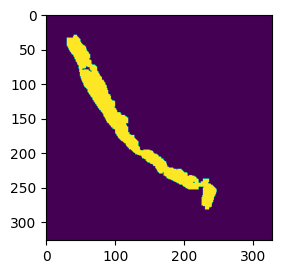

In [19]:
fixed_foreground_mask = matcher.tissue_detector.predict(thumbnail_fixed, open_operation=True)

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.imshow(fixed_foreground_mask)

In [20]:
offset_dict = matcher.match_sample_patches(fixed_wsi_obj, float_wsi_obj, indices_dict, matcher.layer_patch_num, matcher.layer_patch_size, layer_rescale_factors)

In [21]:
fixed_wsi_obj.level_dimensions

((32768, 32768),)

In [22]:
l = 1
DEBUG = True
layer_patch_size = matcher.layer_patch_size
patches_match_offset_dic = {}
[fixed_loc_x, fixed_loc_y], [float_loc_x, float_loc_y] = indices_dict.get("level_" + str(l))
layer_match_offset = []
layer_matched_patch_cnt = 0
for p in range(len(fixed_loc_x)):
    fixed_patch = fixed_wsi_obj.read_region((fixed_loc_y[p], fixed_loc_x[p]), 0, (layer_patch_size[l], layer_patch_size[l])).convert("RGB")
    float_patch = float_wsi_obj.read_region((float_loc_y[p], float_loc_x[p]), 0, (layer_patch_size[l], layer_patch_size[l])).convert("RGB")
    Content_rich_fixed = matcher.filter_by_content_area(np.array(fixed_patch), area_threshold=0.5)
    Content_rich_float = matcher.filter_by_content_area(np.array(float_patch), area_threshold=0.5)
    if Content_rich_fixed and Content_rich_float:
        # p_offset, reg_status = get_initial_pos(fixed_patch, float_patch, layer_rescale_factors[l])
        p_offset, reg_status = matcher.fast_reg(fixed_patch, float_patch, layer_rescale_factors[l])
        print(p_offset)
        if reg_status > 0:
            layer_match_offset.append([p_offset[0], p_offset[1]])
            layer_matched_patch_cnt += 1
        if layer_matched_patch_cnt == layer_patch_num[l]:
            break
logging.debug("Get %d reliable offsets from level %d" % (len(layer_match_offset), l+1))
patches_match_offset_dic["level_" + str(l)] = layer_match_offset
print(patches_match_offset_dic)

{'level_1': []}


In [23]:
Content_rich_float

False

In [24]:
l=0
p=6

fixed_patch = fixed_wsi_obj.read_region((fixed_loc_y[p], fixed_loc_x[p]), 0, (layer_patch_size[l], layer_patch_size[l]))
float_patch = float_wsi_obj.read_region((float_loc_x[p], float_loc_y[p]), 0, (layer_patch_size[l], layer_patch_size[l]))

In [25]:
print(fixed_loc_y[p], fixed_loc_x[p])
print(float_loc_y[p], float_loc_x[p])

22500 27100
24693 29162


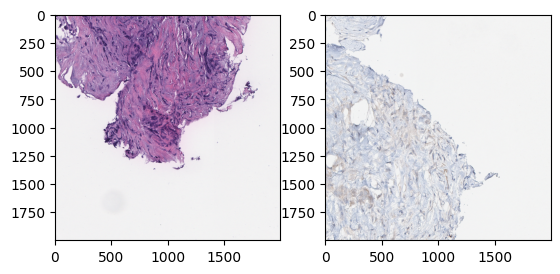

In [26]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.imshow(fixed_patch)
ax2 = fig.add_subplot(122)
ax2.imshow(float_patch)
plt.show()

In [27]:
np.sum(float_patch)

3782209924

In [28]:
patches_match_offset_dic = {}
for l in range(len(matcher.layer_patch_size)):
    [fixed_loc_x, fixed_loc_y], [float_loc_x, float_loc_y] = indices_dict.get("level_" + str(l + 1))
    layer_match_offset = []
    layer_matched_patch_cnt = 0
    for p in range(len(fixed_loc_x)):
        fixed_patch = fixed_wsi_obj.read_region((fixed_loc_y[p], fixed_loc_x[p]), l + 1, (matcher.layer_patch_size[l]//2, matcher.layer_patch_size[l]//2)).convert("RGB")
        float_patch = float_wsi_obj.read_region((float_loc_y[p]-1000, float_loc_x[p]-1000), l + 1, (matcher.layer_patch_size[l], matcher.layer_patch_size[l])).convert("RGB")
        Content_rich_fixed = matcher.filter_by_content_area(np.array(fixed_patch), area_threshold=0.5)
        Content_rich_float = matcher.filter_by_content_area(np.array(float_patch), area_threshold=0.5)
        break
    break

In [29]:
float_patch = float_wsi_obj.read_region((fixed_loc_y[p]+10000, fixed_loc_x[p]-20000), l + 1, (matcher.layer_patch_size[l]*2, matcher.layer_patch_size[l]*2)).convert("RGB")

In [30]:
import matplotlib.pyplot as plt

In [31]:
rgb_image_array = np.array(float_patch)
area_threshold = 0.5
brightness = 85

In [32]:
rgb_image_array

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [33]:
fixed_loc_y[p]

4200

In [34]:
thumbnail_float.size[0]//2

159

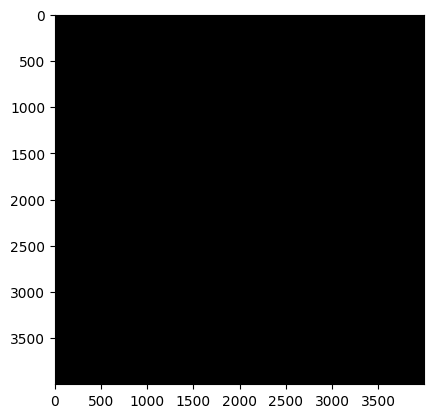

In [35]:
plt.imshow(rgb_image_array)

In [36]:
np.any(rgb_image_array == [0, 0, 0], axis=-1).sum()

16000000

In [37]:
rgb_image_array[np.any(rgb_image_array == [0, 0, 0], axis=-1)] = [255, 255, 255]

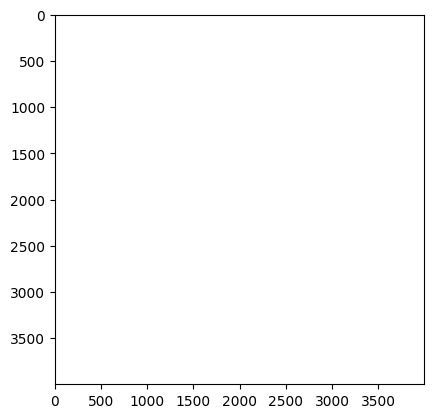

In [38]:
plt.imshow(rgb_image_array)

In [39]:
lab_img = rgb2lab(rgb_image_array)
l_img = lab_img[:, :, 0]

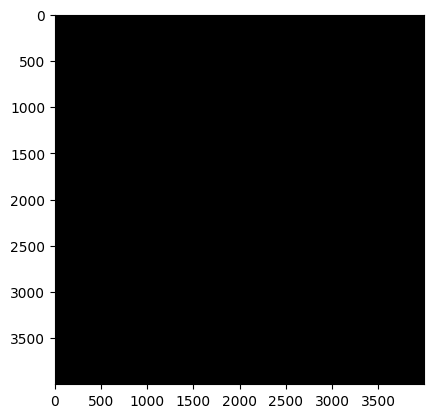

In [40]:
plt.imshow(l_img, cmap="gray")

In [41]:
binary_img = l_img < brightness

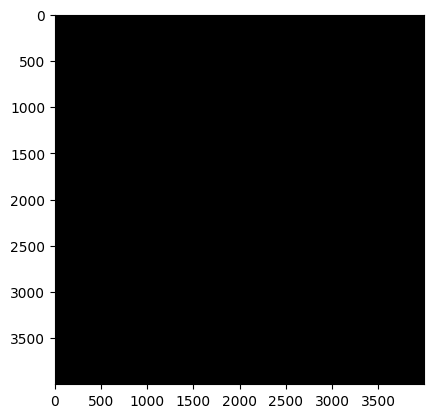

In [42]:
plt.imshow(binary_img, cmap="gray")

In [43]:
tissue_size = np.where(binary_img > 0)[0].size
tissue_ratio = tissue_size*3/rgb_image_array.size  # 3 channels
tissue_ratio > area_threshold

False

In [44]:
%matplotlib inline

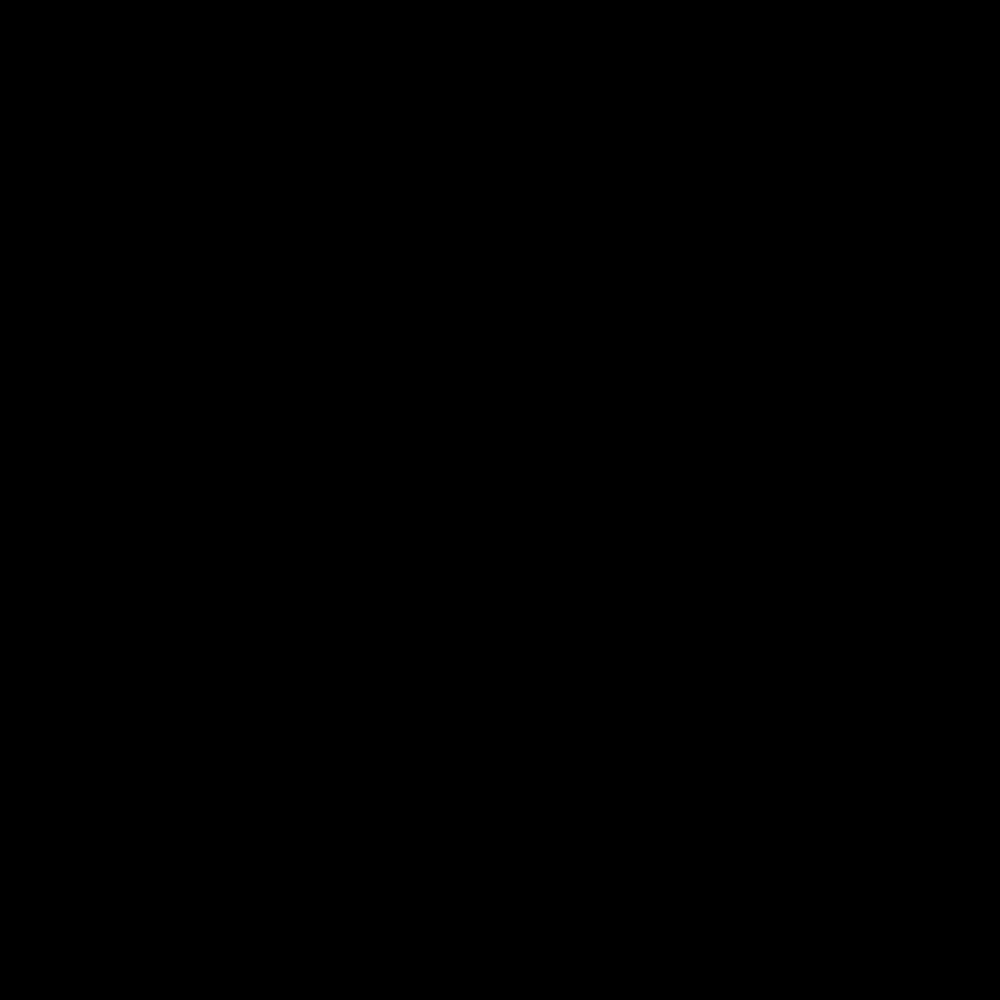

In [45]:
fixed_patch

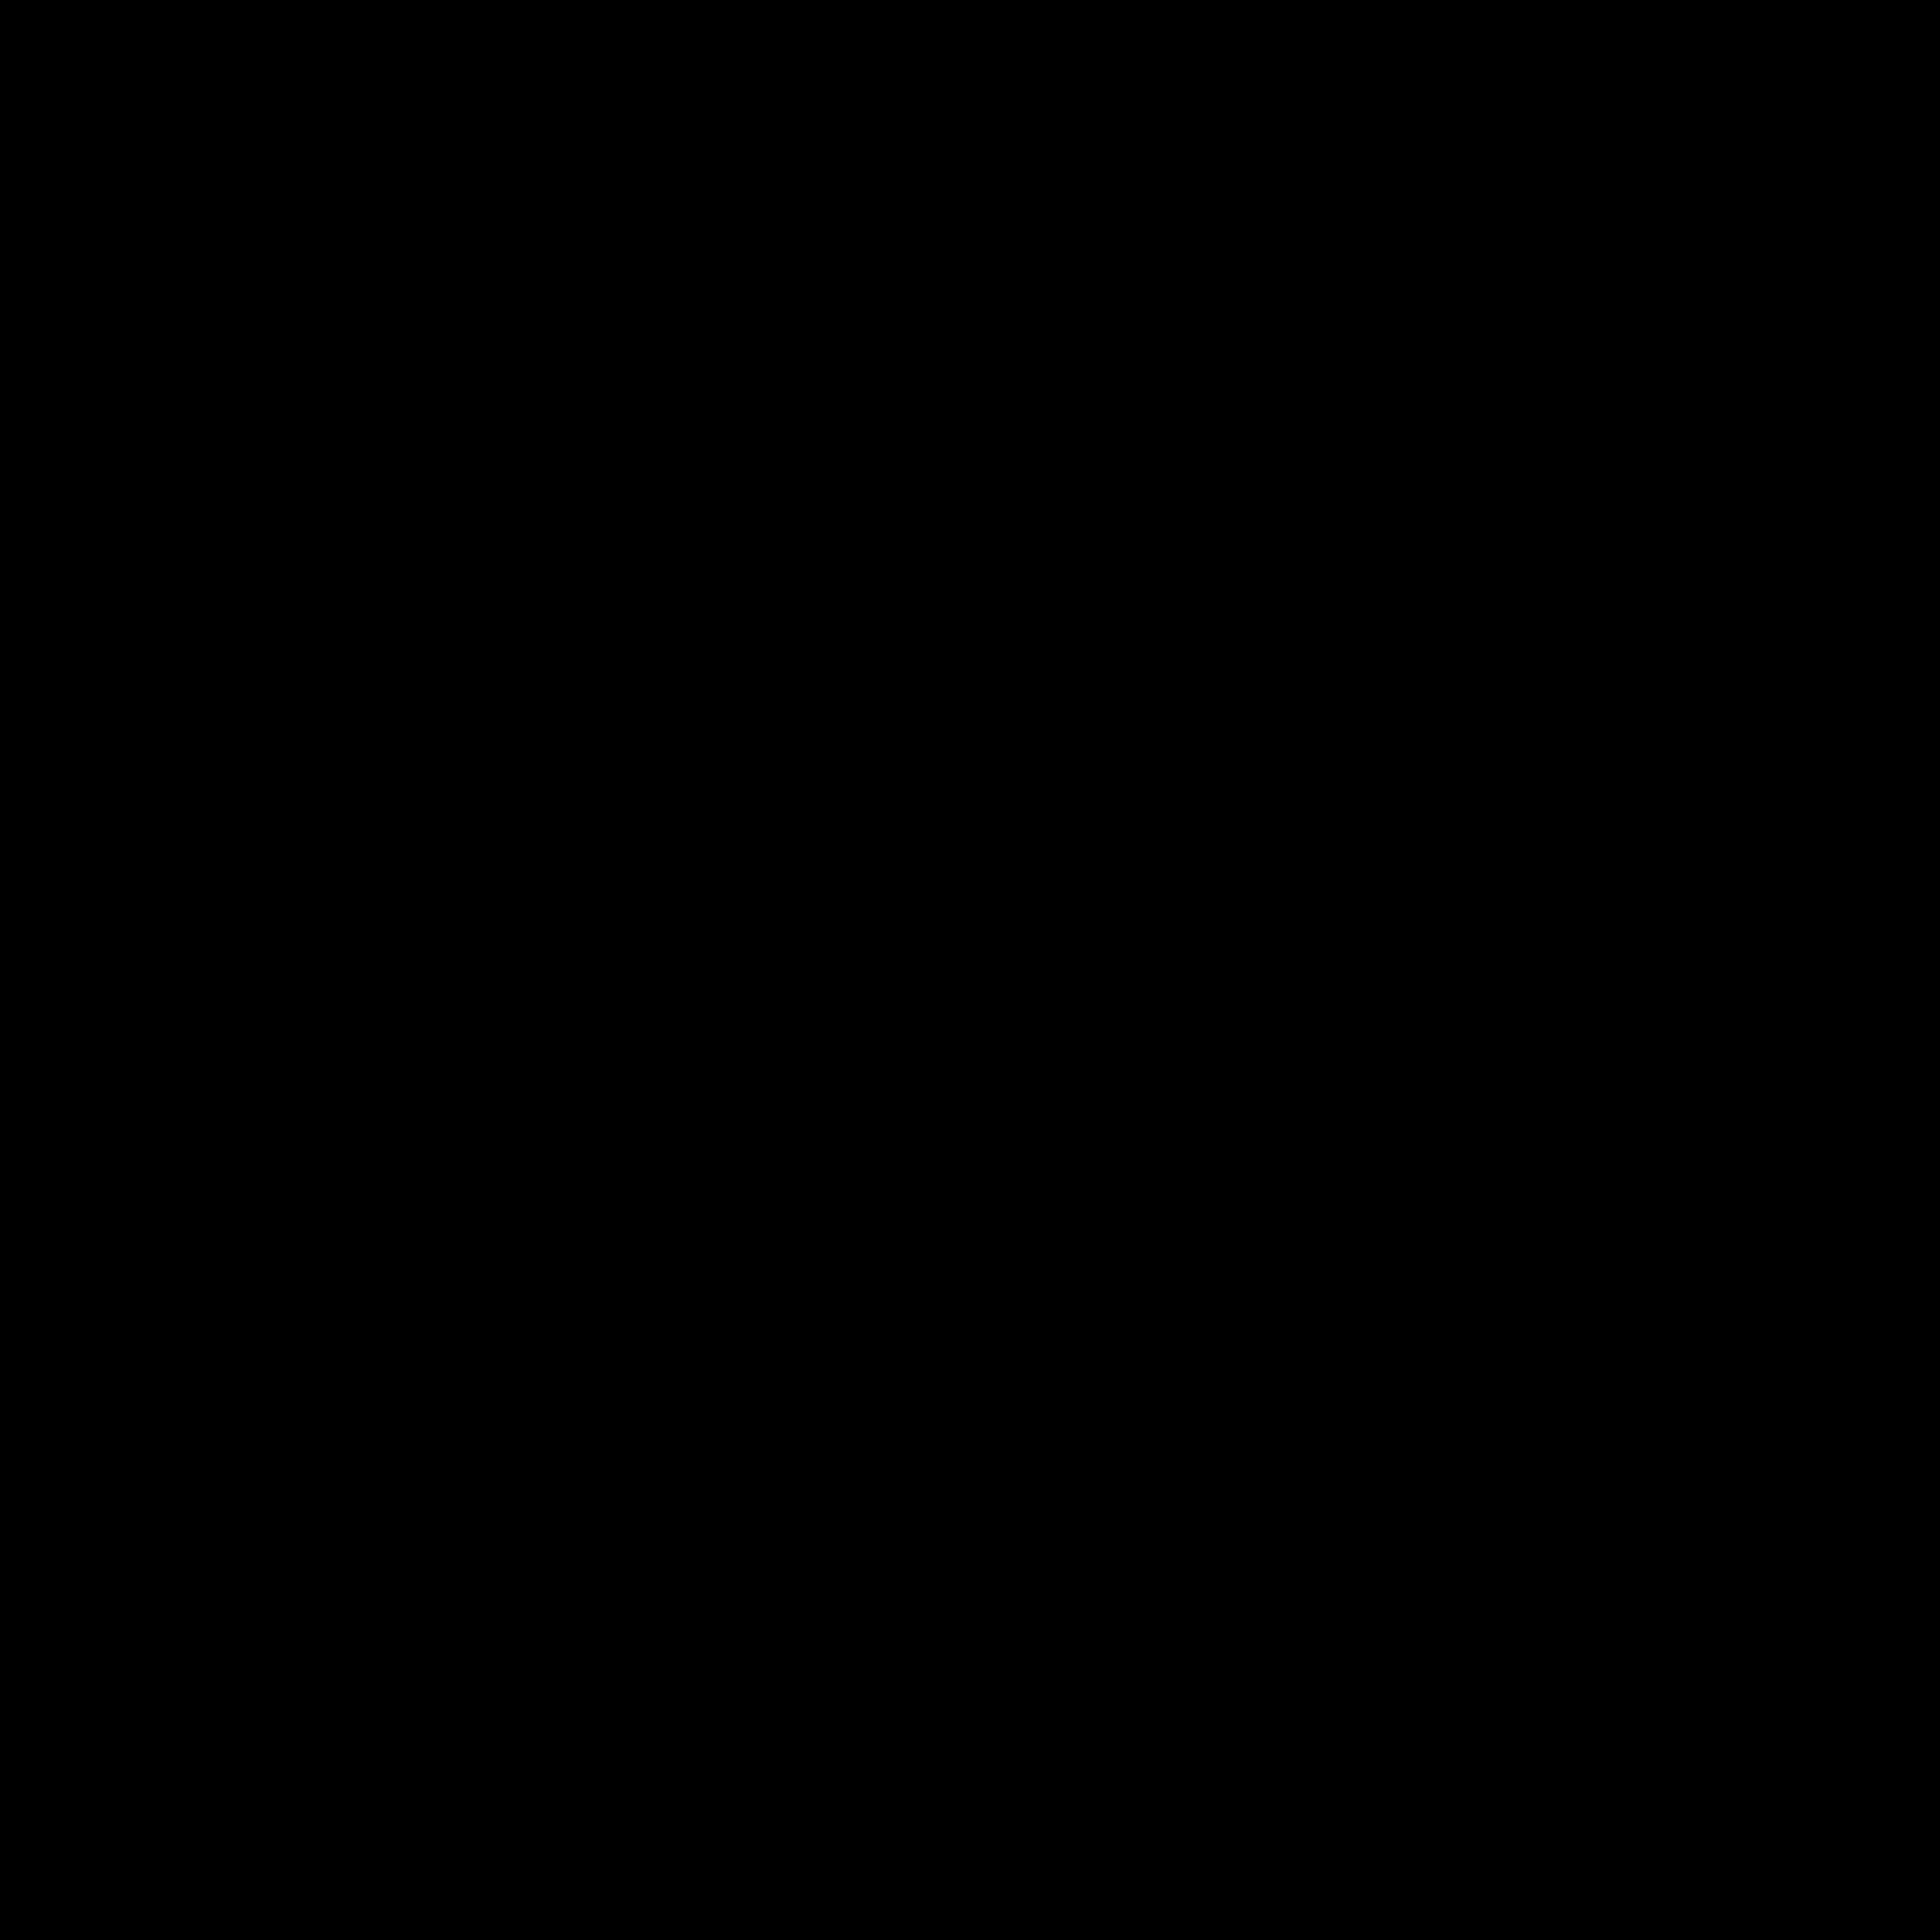

In [46]:
float_patch

In [47]:
offset = matcher.match(fixed_wsi, float_wsi)
logging.debug("Shifting offset: %d %d" % offset)
print("Shifting offset: %d %d" % offset)

/Users/jonlinks/opt/miniconda3/envs/newWSIreg/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/jonlinks/opt/miniconda3/envs/newWSIreg/lib/python3.11/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


ValueError: cannot convert float NaN to integer

In [ ]:
print("Shifting offset: %d %d" % offset)

NameError: name 'offset' is not defined